# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)

# Files

In [2]:
PARAGRAPH = "data/Paragraph.png"
PARAGRAPH_NOISY = "data/ParagraphNoisy.png"
PARAGRAPH_SKEWED = "data/ParagraphSkew.png"
WORD_NOISY = "data/WordNoisy.png"

# Helper Methods

In [3]:
def show_image_at_path(path, name="Image"):
    img = cv2.imread(path)
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def show_image_color(img, name="image"):
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def show_image_gray(img, name="image"):
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(img, cmap='gray')

def get_image(path):
    img = cv2.imread(path)
    return img

In [4]:
def get_elliptic_kernel(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

(83, 205, 3)


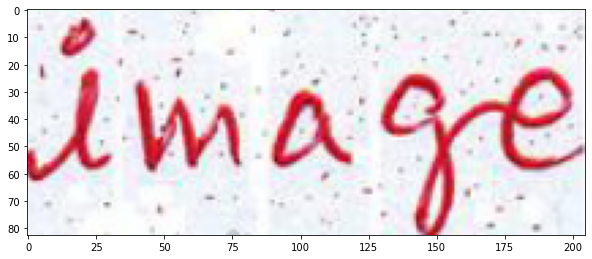

In [5]:
img = get_image(WORD_NOISY)
print(img.shape)
show_image_color(img)

# Preprocessing

(83, 205)


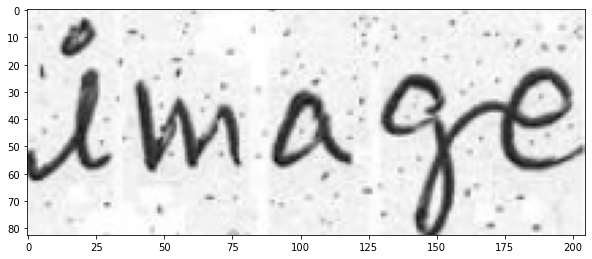

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
show_image_gray(gray)

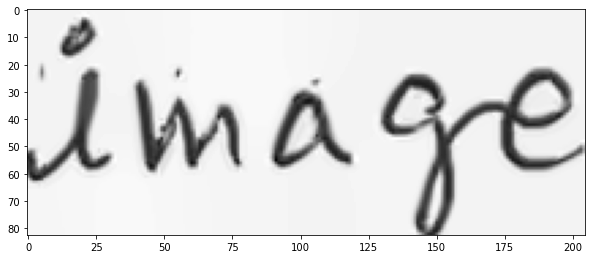

In [7]:
denoise_iters = 10
denoised = cv2.fastNlMeansDenoising(gray,None,10)
for i in range(denoise_iters):
    denoised = cv2.fastNlMeansDenoising(denoised,None,10)
show_image_gray(denoised)

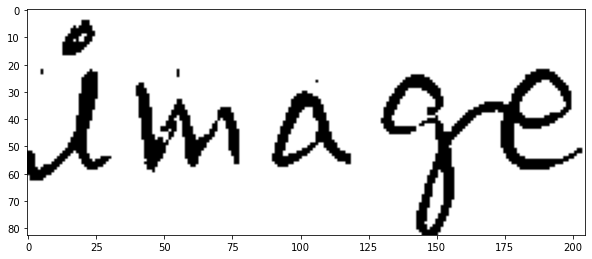

In [8]:
thresh, gray_threshold = cv2.threshold(denoised, 150, 255, cv2.THRESH_BINARY)
show_image_gray(gray_threshold)

### Full Preprocessing Pipeline

In [9]:
def preprocess(
    img, 
    denoise_intensity=10, 
    denoise_iters=10, 
    threshold=150, 
    threshold_max=255,
    thicken=True,
    isBlackBack=False,
    thickenKernel=2,
):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray,None,denoise_intensity)
    for i in range(denoise_iters):
        denoised = cv2.fastNlMeansDenoising(denoised,None,denoise_intensity)
    thresh, gray_threshold = cv2.threshold(denoised, threshold, threshold_max, cv2.THRESH_BINARY)
    if not thicken:
        return gray_threshold
    if isBlackBack : 
        thickened = cv2.dilate(gray_threshold, get_elliptic_kernel(thickenKernel))
    else :
        thickened = cv2.erode(gray_threshold, get_elliptic_kernel(thickenKernel))
    return thickened

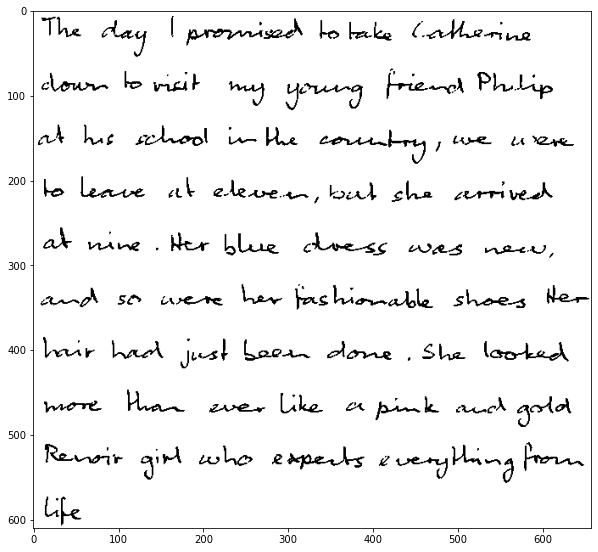

In [10]:
img = get_image(PARAGRAPH)
processed_img = preprocess(img)
show_image_gray(processed_img)

# Histogram Projection

In [11]:
def generate_histogram(img, vertical=False, isBlack = False):
    if vertical :
        if isBlack :
            sm = np.sum(img, axis=0)/255
        else :
            sm = img.shape[0] - np.sum(img, axis=0)/255
    else :
        if isBlack :
            sm = np.sum(img, axis=1)/255
        else :
            sm = img.shape[1] - np.sum(img, axis=1)/255
    return sm

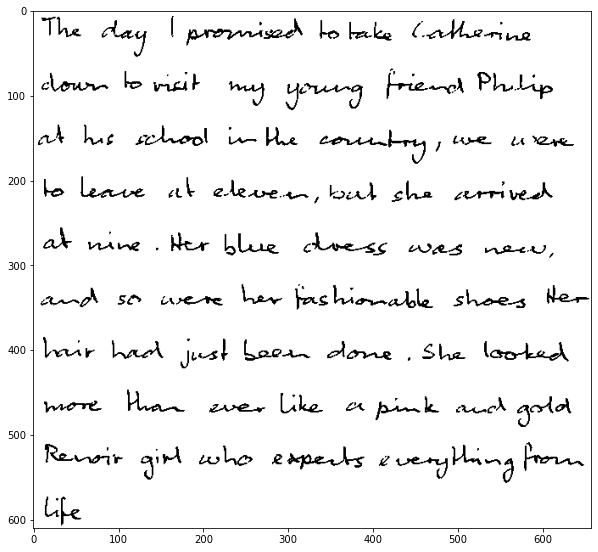

In [12]:
img = get_image(PARAGRAPH)
img2 = preprocess(img)
show_image_gray(img2)

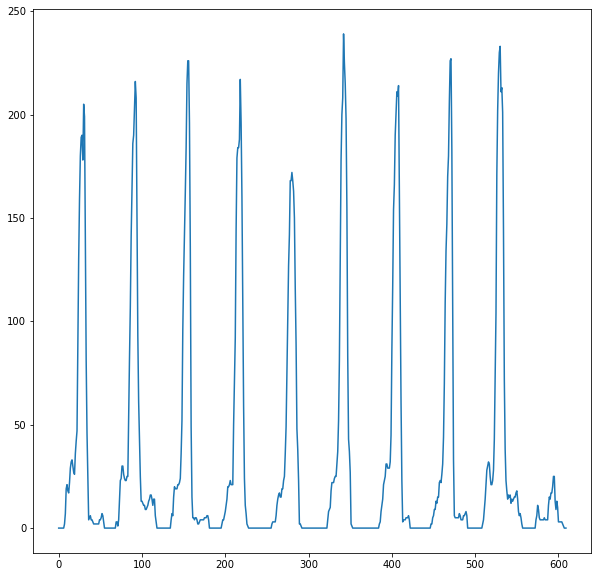

In [13]:
arr = generate_histogram(img2)
plt.plot(arr)

In [14]:
breakpoints = []
min_pixel_thresh = 0
min_length = 10

last = 0
isLow = True
for ind,i in enumerate(arr):
    if isLow and i<=min_pixel_thresh:
        continue
    elif not isLow and i<=min_pixel_thresh : 
        isLow = True
    elif isLow and i>min_pixel_thresh:
        if ind-last<min_length :
            continue
        breakpoints.append((last+ind)//2)
        last = ind
        isLow = False
    else :
        last = ind
breakpoints.append(len(arr)-1)

print(len(breakpoints))
print(breakpoints)

11
[5, 61, 126, 188, 241, 307, 368, 434, 499, 564, 609]


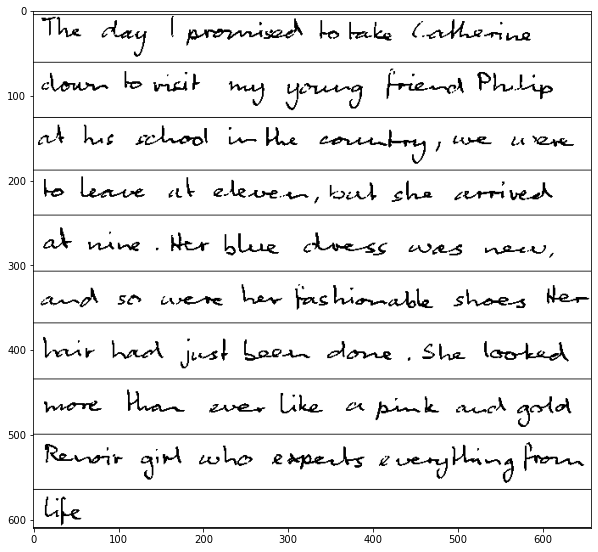

In [15]:
img3 = img2.copy()
for breakpoint in breakpoints :
    cv2.line(img3,  (0, breakpoint), (img3.shape[1], breakpoint), (0, 255, 255), 1)
show_image_gray(img3)

### Sentence Breakpoints pipeline

In [16]:
def getSentenceBreakpoints(
    img,
    min_pixel_thresh = 0,
    min_length = 10
):
    arr = generate_histogram(img)
    breakpoints = []

    last = 0
    isLow = True
    for ind,i in enumerate(arr):
        if isLow and i<=min_pixel_thresh:
            continue
        elif not isLow and i<=min_pixel_thresh : 
            isLow = True
        elif isLow and i>min_pixel_thresh:
            isLow = False
            if (ind-last)<min_length :
                continue
            breakpoints.append((last+ind)//2)
            last = ind
        else :
            last = ind
    breakpoints.append(len(arr)-1)
    return breakpoints

def drawSentenceBreakpoints(img, breakpoints):
    img2 = img.copy()
    for breakpoint in breakpoints :
        cv2.line(img2,  (0, breakpoint), (img2.shape[1], breakpoint), (0, 255, 255), 1)
    return img2

def getSentenceSnips(img, breakpoints):
    arr = []
    last = breakpoints[0]
    for breakpoint in breakpoints[1:]:
        arr.append(img[last:breakpoint])
        last = breakpoint
    return arr

In [17]:
img = get_image(PARAGRAPH)
img2 = preprocess(img)
breakpoints = getSentenceBreakpoints(img2)

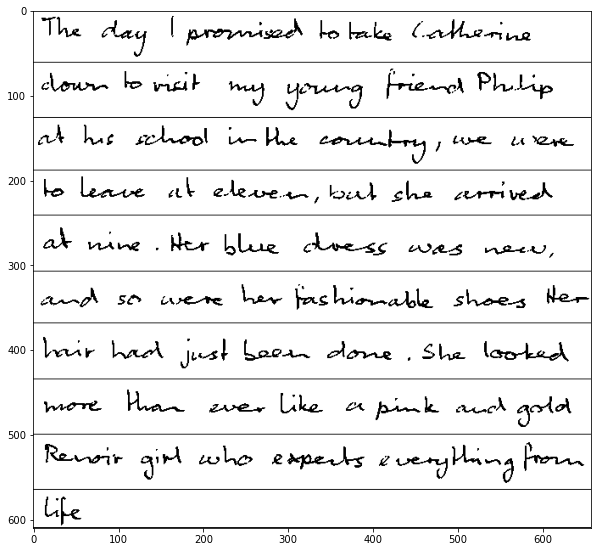

In [18]:
img3 = drawSentenceBreakpoints(img2, breakpoints)
show_image_gray(img3)

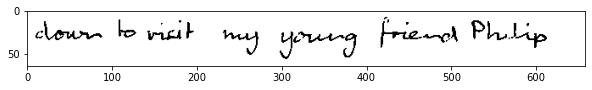

In [19]:
sentences = getSentenceSnips(img2, breakpoints)
show_image_gray(sentences[0])

### Word Breakpoints Pipeline

In [20]:
def getWordBreakpoints(
    img,
    min_pixel_thresh = 0,
    min_length = 10
):
    arr = generate_histogram(img, vertical=True)
    breakpoints = []

    last = 0
    isLow = True
    for ind,i in enumerate(arr):
        if isLow and i<=min_pixel_thresh:
            continue
        elif not isLow and i<=min_pixel_thresh : 
            isLow = True
        elif isLow and i>min_pixel_thresh:
            isLow = False
            if (ind-last)<min_length :
                continue
            breakpoints.append((last+ind)//2)
            last = ind
        else :
            last = ind
    breakpoints.append(len(arr)-1)
    return breakpoints

def drawWordBreakpoints(img, breakpoints):
    img2 = img.copy()
    for breakpoint in breakpoints :
        cv2.line(img2,  (breakpoint, 0), (breakpoint, img2.shape[1]), (0, 255, 255), 1)
    return img2

def getWordSnips(img, breakpoints):
    arr = []
    last = breakpoints[0]
    for breakpoint in breakpoints[1:]:
        arr.append(img[:, last:breakpoint])
        last = breakpoint
    return arr

[5, 98, 135, 213, 285, 402, 515, 657]


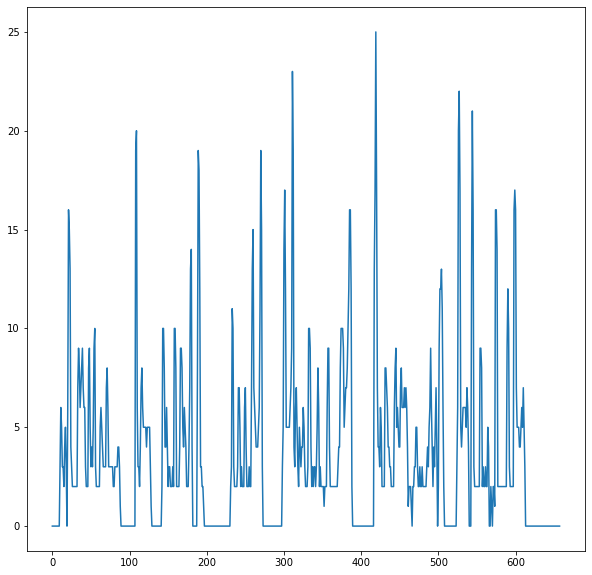

In [21]:
sentence = sentences[0]
breakpoints = getWordBreakpoints(sentence, min_length=10)
plt.plot(generate_histogram(sentence, vertical=True))
print(breakpoints)

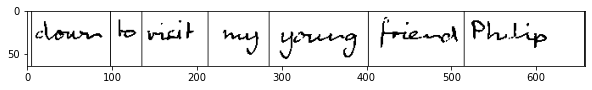

In [22]:
words_drawn = drawWordBreakpoints(sentence, breakpoints)
show_image_gray(words_drawn)

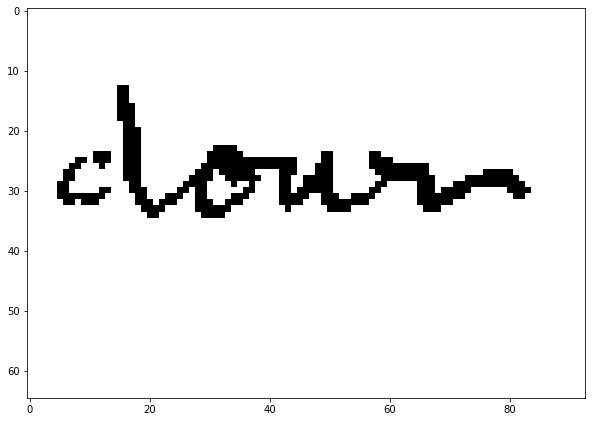

In [23]:
words = getWordSnips(sentence, breakpoints)
show_image_gray(words[0])

# Image Alignment Finder  (TBD)

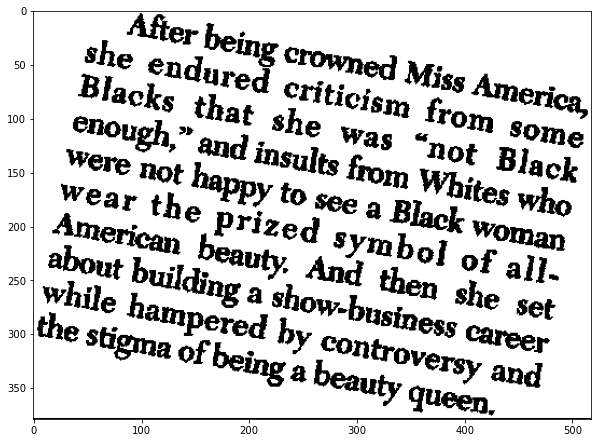

In [24]:
img = get_image(PARAGRAPH_SKEWED)
img2 = preprocess(img)
breakpoints = getSentenceBreakpoints(img2)
img3 = drawSentenceBreakpoints(img2, breakpoints)
show_image_gray(img3)

# Character Divider (TBD)